# Inspect Best Student vs Teacher on Full Audio

This notebook loads the trained TinyVAD student checkpoint and the Silero teacher,
then visualizes their probability alignment on any audio clip. Update the
`audio_path` assignment at the bottom to target your file.


C:\Users\xeangao\AppData\Local\Temp\ipykernel_40848\1235175752.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(student_checkpoint, map_location

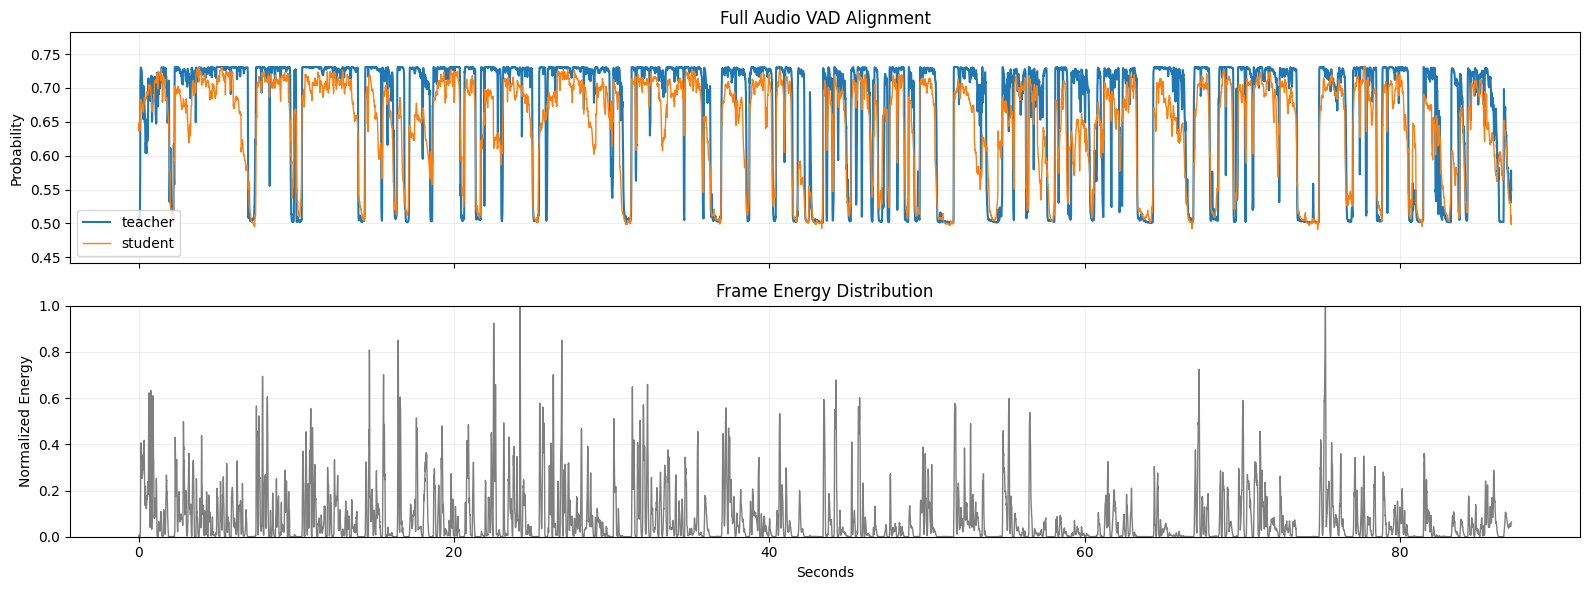

In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from vad_distill.config import load_config
from vad_distill.config.data_paths import resolve_paths
from vad_distill.preprocessing.audio_utils import compute_log_mel, load_audio
from vad_distill.teacher.frame_level_teacher import FrameLevelTeacher
from vad_distill.tiny_vad.model import build_tiny_vad_model

config = load_config()
paths = resolve_paths(config.get("paths", {}))


def run_teacher_on_full_audio(audio_tensor: torch.Tensor, teacher_cfg: dict) -> np.ndarray:
    window_size = int(teacher_cfg.get("window_size", 512))
    hop_size = int(teacher_cfg.get("hop_size", 160))
    device = teacher_cfg.get("device", "auto")
    teacher = FrameLevelTeacher(device=device, window_size=window_size, hop_size=hop_size)
    probs, _ = teacher.infer(audio_tensor.cpu().numpy(), sr=16_000)
    return probs.astype(np.float32)


def extract_normalized_mel(waveform: np.ndarray, chunk_cfg: dict) -> torch.Tensor:
    mel = compute_log_mel(
        waveform,
        sample_rate=16_000,
        n_mels=int(chunk_cfg["n_mels"]),
        frame_len=float(chunk_cfg["frame_len"]),
        frame_hop=float(chunk_cfg["frame_hop"]),
    )
    mel = (mel - mel.mean()) / (mel.std() + 1e-6)
    return torch.from_numpy(mel).to(torch.float32)


def compute_frame_energy(
    waveform: np.ndarray,
    sample_rate: int,
    frame_len: float,
    frame_hop: float,
) -> np.ndarray:
    frame_size = int(round(frame_len * sample_rate))
    hop_size = int(round(frame_hop * sample_rate))
    if frame_size <= 0 or hop_size <= 0:
        raise ValueError("Invalid frame configuration for energy computation.")
    energies: list[float] = []
    start = 0
    total = len(waveform)
    while start < total:
        end = start + frame_size
        frame = waveform[start:end]
        if frame.shape[0] < frame_size:
            pad = np.zeros(frame_size, dtype=np.float32)
            pad[: frame.shape[0]] = frame
            frame = pad
        energy = float(np.mean(frame**2))
        energies.append(energy)
        if end >= total:
            break
        start += hop_size
    energy_arr = np.asarray(energies, dtype=np.float32)
    if energy_arr.size == 0:
        return np.zeros(0, dtype=np.float32)
    energy_arr = (energy_arr - energy_arr.min()) / (energy_arr.max() - energy_arr.min() + 1e-8)
    return energy_arr


def run_student_chunks(
    mel_tensor: torch.Tensor,
    student_model: torch.nn.Module,
    chunk_size: int,
    stride: int,
    device: torch.device,
) -> np.ndarray:
    mel_tensor = mel_tensor.to(device)
    num_frames = mel_tensor.shape[0]
    if num_frames == 0:
        return np.zeros(0, dtype=np.float32)
    if num_frames < chunk_size:
        pad = chunk_size - num_frames
        pad_frame = mel_tensor[-1:].repeat(pad, 1)
        mel_tensor = torch.cat([mel_tensor, pad_frame], dim=0)
        num_frames = chunk_size

    accum = torch.zeros(num_frames, dtype=torch.float32, device=device)
    counts = torch.zeros(num_frames, dtype=torch.float32, device=device)

    starts = range(0, num_frames, stride)
    student_model.eval()
    with torch.no_grad():
        for start in starts:
            end = min(start + chunk_size, num_frames)
            chunk = mel_tensor[start:end]
            valid_len = end - start
            if valid_len < chunk_size:
                pad = mel_tensor[-1:].repeat(chunk_size - valid_len, 1)
                chunk = torch.cat([chunk, pad], dim=0)
            chunk = chunk.unsqueeze(0)
            prob = torch.sigmoid(student_model(chunk)).squeeze(0)
            accum[start:end] += prob[:valid_len]
            counts[start:end] += 1.0

    torch.clamp_(counts, min=1.0)
    student_full = (accum / counts).cpu().numpy().astype(np.float32)
    return student_full


def plot_audio_vad_alignment(audio_path, student_checkpoint, config) -> None:
    audio_path = Path(audio_path)
    chunk_cfg = config.get("chunking", {})
    teacher_cfg = config.get("teacher", {})
    waveform = load_audio(audio_path, target_sr=16_000)
    audio_tensor = torch.from_numpy(waveform).to(torch.float32)
    teacher_full = run_teacher_on_full_audio(audio_tensor, teacher_cfg)
    mel_tensor = extract_normalized_mel(waveform, chunk_cfg)
    energy_full = compute_frame_energy(
        waveform,
        sample_rate=16_000,
        frame_len=float(chunk_cfg["frame_len"]),
        frame_hop=float(chunk_cfg["frame_hop"]),
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    student = build_tiny_vad_model(config).to(device)
    checkpoint = torch.load(student_checkpoint, map_location=device)
    state_dict = checkpoint.get("model_state_dict", checkpoint)
    student.load_state_dict(state_dict)
    student.eval()

    chunk_size = int(chunk_cfg["chunk_size"])
    stride = int(chunk_cfg["stride"])
    student_full = run_student_chunks(mel_tensor, student, chunk_size, stride, device)
    student_full = student_full[: len(mel_tensor)]

    min_len = min(len(teacher_full), len(student_full), len(energy_full))
    if min_len == 0:
        raise ValueError("Empty alignment: check audio length or chunking settings.")
    teacher_full = teacher_full[:min_len]
    student_full = student_full[:min_len]
    energy_full = energy_full[:min_len]
    frame_hop = float(chunk_cfg["frame_hop"])
    time_axis = np.arange(min_len) * frame_hop

    fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=True)
    axes[0].plot(time_axis, teacher_full, label="teacher", linewidth=1.5)
    axes[0].plot(time_axis, student_full, label="student", linewidth=1.0)
    ymin = min(teacher_full.min(), student_full.min()) - 0.05
    ymax = max(teacher_full.max(), student_full.max()) + 0.05
    axes[0].set_ylim(ymin, ymax)
    axes[0].set_ylabel("Probability")
    axes[0].set_title("Full Audio VAD Alignment")
    axes[0].legend()
    axes[0].grid(True, alpha=0.2)

    axes[1].plot(time_axis, energy_full, color="tab:gray", linewidth=1.0)
    axes[1].set_ylim(0, 1)
    axes[1].set_xlabel("Seconds")
    axes[1].set_ylabel("Normalized Energy")
    axes[1].set_title("Frame Energy Distribution")
    axes[1].grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()


student_checkpoint = paths["checkpoint_dir"] / "best.pt"
audio_path = Path("demo.opus")

assert student_checkpoint.exists(), f"Missing checkpoint: {student_checkpoint}"
assert audio_path.exists(), f"Missing audio file: {audio_path}"

plot_audio_vad_alignment(
    audio_path,
    student_checkpoint=student_checkpoint,
    config=config,
)

